In [1]:
# Importing the libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

import numpy as np
from tensorflow.keras.preprocessing import image

In [2]:
#data sugmentation
# Preprocessing the Training set
train_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')
training_set = train_datagen.flow_from_directory('image_data/training',
                                                 target_size = (224,224),
                                                 batch_size = 198,
                                                 class_mode = 'binary')

Found 198 images belonging to 2 classes.


In [3]:
# Preprocessing the Test set
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('image_data/validation',
                                            target_size = (224,224),
                                            batch_size = 100,
                                            class_mode = 'binary')

Found 100 images belonging to 2 classes.


In [4]:
X_train, y_train = next(training_set)
y_train = y_train.astype(int)

X_test, y_test = next(test_set)
y_test = y_test.astype(int)

In [5]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((198, 224, 224, 3), (198,), (100, 224, 224, 3), (100,))

In [6]:
training_set.class_indices

{'Cat': 0, 'Dog': 1}

## Apply Smote For Balancing Data

In [7]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_rows=len(X_train)
X_train_reshape =X_train.reshape(X_train_rows,-1)
X_train_resample, y_train_resample = sm.fit_resample(X_train_reshape, y_train)
X_train_resample = X_train_resample.reshape(-1,224, 224, 3)

In [8]:
X_val_rows=len(X_test)
X_val_reshape =X_test.reshape(X_val_rows,-1)
X_val_resample, y_val_resample = sm.fit_resample(X_val_reshape, y_test)
X_val_resample = X_val_resample.reshape(-1,224, 224, 3)

In [9]:
X_train_resample.shape,y_train_resample.shape,X_val_resample.shape,y_val_resample.shape

((198, 224, 224, 3), (198,), (100, 224, 224, 3), (100,))

## Overview Of Image

In [10]:
## showing some image from training
import matplotlib.pyplot as plt
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

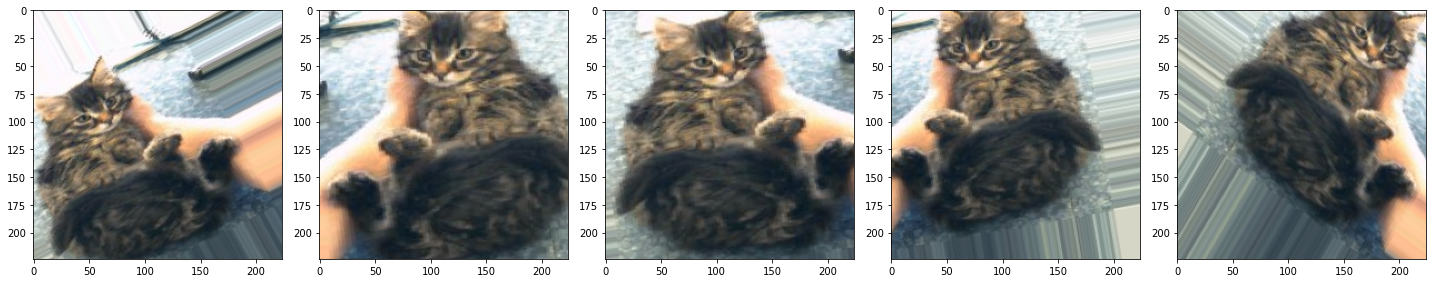

In [11]:
images = [training_set[0][0][0] for i in range(5)]
plotImages(images)

## Using Machine Learning

In [12]:
#sklearn expects i/p to be 2d array-model.fit(x_train,y_train)=>reshape to 2d array
nsamples, nx, ny, nrgb = X_train_resample.shape
x_train2 = X_train_resample.reshape((nsamples,nx*ny*nrgb))

nsamples, nx, ny, nrgb = X_val_resample.shape
x_test2 = X_val_resample.reshape((nsamples,nx*ny*nrgb))

In [13]:
x_train2.ndim

2

In [14]:
x_train2.shape,x_test2.shape,y_train.shape,y_test.shape

((198, 150528), (100, 150528), (198,), (100,))

## Implementing a Random Forest Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(random_state=21)
model.fit(x_train2,y_train_resample)
y_pred=model.predict(x_test2)
print(accuracy_score(y_pred,y_val_resample))
print(classification_report(y_pred,y_val_resample))

0.57
              precision    recall  f1-score   support

           0       0.56      0.57      0.57        49
           1       0.58      0.57      0.57        51

    accuracy                           0.57       100
   macro avg       0.57      0.57      0.57       100
weighted avg       0.57      0.57      0.57       100



## Implementing a KNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=7)
knn.fit(x_train2,y_train_resample)
y_pred_knn=knn.predict(x_test2)
print(accuracy_score(y_pred_knn,y_val_resample))
print(classification_report(y_pred_knn,y_val_resample))

0.41
              precision    recall  f1-score   support

           0       0.48      0.42      0.45        57
           1       0.34      0.40      0.37        43

    accuracy                           0.41       100
   macro avg       0.41      0.41      0.41       100
weighted avg       0.42      0.41      0.41       100



## Implementing a Decision Tree

In [17]:
from sklearn.tree import DecisionTreeClassifier
dtc=DecisionTreeClassifier()
dtc.fit(x_train2,y_train_resample)
y_pred_dtc=dtc.predict(x_test2)
print(accuracy_score(y_pred_dtc,y_val_resample))
print(classification_report(y_pred_dtc,y_val_resample))

0.57
              precision    recall  f1-score   support

           0       0.66      0.56      0.61        59
           1       0.48      0.59      0.53        41

    accuracy                           0.57       100
   macro avg       0.57      0.57      0.57       100
weighted avg       0.59      0.57      0.57       100



In [18]:
classes = ['cat','dog']

In [19]:
# test_image = image.load_img('dog.jpg', target_size = (224,224))
# test_image = image.img_to_array(test_image)
# #so,eventually,model.predict() should also be a 2d inpu
# nx, ny, nrgb = test_image.shape
# test_image= test_image.reshape(1,(nx*ny*nrgb))

# test_image=test_image/255
# # test_image = np.expand_dims(test_image, axis = 0)
# result = dtc.predict(test_image)[0]
# classes[result]

## Using deep learning CNN Architecture

In [20]:
from tensorflow.keras.layers import Conv2D

In [21]:
# Part 2 - Building the CNN

# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - # Adding a first convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32,padding="same",kernel_size=3, activation='relu', input_shape=[224,224, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding a second convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32,padding='same',kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

###ann layer
tf.keras.layers.Dropout(0.5)
# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
tf.keras.layers.Dropout(0.5)

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [22]:
# Part 3 - Training the CNN

# Compiling the CNN
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [23]:
# Training the CNN on the Training set and evaluating it on the Test set
history = cnn.fit(X_train_resample,y_train_resample, validation_data = (X_val_resample,y_val_resample), epochs = 2)

Epoch 1/2
7/7 [==============================] - 13s 2s/step - loss: 5.1117 - accuracy: 0.4545 - val_loss: 2.0350 - val_accuracy: 0.5000
Epoch 2/2
7/7 [==============================] - 11s 2s/step - loss: 1.0329 - accuracy: 0.5152 - val_loss: 0.7036 - val_accuracy: 0.4900


In [24]:
# Score trained model.
scores = cnn.evaluate(X_val_resample,y_val_resample, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = cnn.predict(X_val_resample)
Y_pred_classes = np.argmax(pred, axis=1) 

4/4 [==============================] - 1s 314ms/step - loss: 0.7036 - accuracy: 0.4900
Test loss: 0.7035805583000183
Test accuracy: 0.49000000953674316


### Custom Prediction

In [25]:
# Part 4 - Making a single prediction

import numpy as np
from tensorflow.keras.preprocessing import image
test_image = image.load_img('6.jpg', target_size = (224,224))
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)[0]
if result[0]<=0.5:
    print("The image classified is cat")
else:
    print("The image classified is dog")

The image classified is dog


## Using Transfer Learning

In [26]:
from tensorflow.keras.applications import MobileNet
from keras import Model,Sequential

In [27]:
mobile_net = MobileNet(input_shape=(224,224,3),weights='imagenet')
mobile_net.trainable = False

In [28]:
model = Sequential([
    mobile_net,
    ### ann layer
    tf.keras.layers.Dense(1, activation='sigmoid') #[0, 1] or [1, 0]
    ])

In [29]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [30]:
history = model.fit(
    X_train_resample,y_train_resample,
    epochs=2,
    validation_data=(X_val_resample,y_val_resample)
    )

Epoch 1/2
7/7 [==============================] - 14s 2s/step - loss: 0.6914 - accuracy: 0.5354 - val_loss: 0.6929 - val_accuracy: 0.4900
Epoch 2/2
7/7 [==============================] - 10s 2s/step - loss: 0.6892 - accuracy: 0.6061 - val_loss: 0.6911 - val_accuracy: 0.5300


In [31]:
# Score trained model.
scores = model.evaluate(X_val_resample,y_val_resample, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model.predict(X_val_resample)
Y_pred_classes = np.argmax(pred, axis=1) 

4/4 [==============================] - 4s 765ms/step - loss: 0.6911 - accuracy: 0.5300
Test loss: 0.6910582780838013
Test accuracy: 0.5299999713897705


## Using LSTM

In [32]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

In [33]:
x_train2.shape,x_test2.shape

((198, 150528), (100, 150528))

In [34]:
x_train2 = x_train2.reshape(x_train2.shape[0],x_train2.shape[1]//150528,150528)
x_test2 = x_test2.reshape(x_test2.shape[0],x_test2.shape[1]//150528,150528)

In [35]:
x_train2.shape,x_test2.shape

((198, 1, 150528), (100, 1, 150528))

In [36]:
model = Sequential()
model.add(LSTM(288, input_shape=( 1, 150528), return_sequences = True))
model.add(LSTM(288,activation='relu'))
model.add(Dense(1,activation='tanh'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 288)            173741184 
                                                                 
 lstm_1 (LSTM)               (None, 288)               664704    
                                                                 
 dense_3 (Dense)             (None, 1)                 289       
                                                                 
Total params: 174,406,177
Trainable params: 174,406,177
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train2, y_train, epochs=2, validation_data=(x_test2, y_test),batch_size=256, verbose=2)

Epoch 1/2
1/1 - 11s - loss: 3.9607 - accuracy: 0.5000 - val_loss: 0.7741 - val_accuracy: 0.5000 - 11s/epoch - 11s/step
Epoch 2/2
1/1 - 4s - loss: 0.7726 - accuracy: 0.5000 - val_loss: 0.8314 - val_accuracy: 0.5000 - 4s/epoch - 4s/step


In [38]:
# Score trained model.
scores = model.evaluate(x_test2, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model.predict(x_test2)
Y_pred_classes = np.argmax(pred, axis=1) 

4/4 [==============================] - 1s 260ms/step - loss: 0.8314 - accuracy: 0.5000
Test loss: 0.8313990831375122
Test accuracy: 0.5


## Ensemble CNN with RNN

In [39]:
from keras.layers import LSTM, TimeDistributed, Dense, Input,Flatten
from tensorflow.keras.applications import MobileNet
from keras.models import Sequential, Model

In [40]:
inp = Input(shape=(224,224,3))
MobileNet = MobileNet(include_top=False, weights='imagenet', input_tensor=inp)
x = MobileNet.output

#Really depends on whether you want pre-trained values to be fixed or not
for layer in MobileNet.layers:
    layer.trainable = False 

#Add here whatever dense layers you need
x = TimeDistributed(Flatten())(x)
x = LSTM(10, return_sequences=False, dropout=0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)

In [41]:
my_model = Model(inputs=MobileNet.inputs, outputs=predictions)

In [42]:
my_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
hist = my_model.fit(
    X_train_resample,y_train_resample,
    epochs=2,
    validation_data=(X_val_resample,y_val_resample)
    )

Epoch 1/2
7/7 [==============================] - 17s 2s/step - loss: 0.6658 - accuracy: 0.5556 - val_loss: 0.5444 - val_accuracy: 0.8500
Epoch 2/2
7/7 [==============================] - 11s 2s/step - loss: 0.4508 - accuracy: 0.8939 - val_loss: 0.3577 - val_accuracy: 0.9100


In [44]:
# Score trained model.
scores = my_model.evaluate(X_val_resample,y_val_resample, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = my_model.predict(X_val_resample)
Y_pred_classes = np.argmax(pred, axis=1) 

4/4 [==============================] - 4s 834ms/step - loss: 0.3577 - accuracy: 0.9100
Test loss: 0.3577404022216797
Test accuracy: 0.9100000262260437


## Comparision

In [49]:
from prettytable import PrettyTable
x = PrettyTable()

In [50]:
x.field_names = ["Model name", "Accuracy","Loss"]
x.add_row(["Random_Forest", 57,0.65])
x.add_row(["KNN", 41,0.12])
x.add_row(["Decision_Tree", 57,0.65])
x.add_row(["CNN", 49,0.70])
x.add_row(["Transfer_Learning", 52,0.69])
x.add_row(["LSTM", 50,0.83])
x.add_row(["CNN with LSTM", 91,0.35])
print(x)

+-------------------+----------+------+
|     Model name    | Accuracy | Loss |
+-------------------+----------+------+
|   Random_Forest   |    57    | 0.65 |
|        KNN        |    41    | 0.12 |
|   Decision_Tree   |    57    | 0.65 |
|        CNN        |    49    | 0.7  |
| Transfer_Learning |    52    | 0.69 |
|        LSTM       |    50    | 0.83 |
|   CNN with LSTM   |    91    | 0.35 |
+-------------------+----------+------+


### In this comparision it concluded that CNN with LSTM  gives highest accuracy with lower loss value.